In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style='darkgrid', palette='colorblind')
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path    = 'data/'  # If data in 'data' directory
delian = pd.read_excel(path + 'DeLiAn_edited.xlsx', sheet_name=None) 
#DeLiAn_edited is just DeLiAn with the sheets rearranged in the proper order 
#(an  intensive optical property followed by its errors)

Now delian is a dictionary where **each key is the sheet name** and **each value is the corresponding DataFrame**.

In [3]:
for sheet_name, df in delian.items():
    print(f"Sheet Name: {sheet_name}")
    print(df.head())
    print("----------------------------------------------------------------")

Sheet Name: List of variables
   Sheet                            Variables (unit)  \
0      1   angstrom_exponent_backscatter_355_532 (1)   
1      2  angstrom_exponent_backscatter_532_1064 (1)   
2      3    angstrom_exponent_extinction_355_532 (1)   
3      4                                 campaign_rv   
4      5                                        date   

                                         Description  
0  Angstrom exponent at 355/532 nm backscatter-re...  
1  Angstrom exponent at 532/1064 nm backscatter-r...  
2  Angstrom exponent at 355/532 nm extinction-rel...  
3     Name of the campaign or of the research vessel  
4  Date of the lidar observations (DD-MM-YYYY or ...  
----------------------------------------------------------------
Sheet Name: 1
       Ash  Saharan dust  Central Asian dust  Middle Eastern dust   Smoke  \
0 -9999.00       -9999.0           -0.061045              -9999.0 -9999.0   
1 -9999.00       -9999.0           -0.418634                  0.6 -999

We remame the sheets based on the sheet "List of Variables"

In [4]:
variable_names = delian['List of variables']
# Iterate through each sheet and rename them
for sheet_name in delian.keys():
    if sheet_name != 'List of variables':
        # Filter the rows based on the condition and selecting the 'Variables (unit)' column
        new_sheet_name = variable_names.loc[variable_names['Sheet'] == int(sheet_name), 'Variables (unit)'].values[0]
        delian[new_sheet_name] = delian.pop(sheet_name)
        
delian.keys()

dict_keys(['List of variables', 'angstrom_exponent_backscatter_355_532 (1)', 'error_angstrom_exponent_backscatter_355_532 (1)', 'angstrom_exponent_backscatter_532_1064 (1)', 'error_angstrom_exponent_backscatter_532_1064 (1)', 'angstrom_exponent_extinction_355_532 (1)', 'error_angstrom_exponent_extinction_355_532 (1)', 'lidar_ratio_355 (sr)', 'error_lidar_ratio_355 (sr)', 'lidar_ratio_532 (sr)', 'error_lidar_ratio_532 (sr)', 'particle_linear_depolarization_ratio_355 (%)', 'error_particle_linear_depolarization_ratio_355 (%)', 'particle_linear_depolarization_ratio_532 (%)', 'error_particle_linear_depolarization_ratio_532 (%)', 'number_samples (1)', 'campaign_rv', 'date', 'location', 'measurement_type', 'reference', 'system'])


In our database, we have two types of error values: `NaN` and `-9999.0`.

**Why do we have these two types of error values?**

- `-9999.0` means the measured value is in error, i.e. it is synonymous with missing values or NaN in other database. This one is what we need to impute or drop (depending on the method).

- `NaN` means the value is not measured at all (what we have to drop). Because each aerosol has a different number of samples by LiDAR, in each sheet of the original Excel, each column (representing each aerosol) has different lengths. So the columns are padded  to have equal lengths

In short, `NaN` means no measured value while `-9999.0` is an error value.

### **Data Preprocessing**

We have a sheet showing how many times each aerosol type has been sampled (measured) by Lidar.

In [5]:
samples = delian['number_samples (1)']
samples

,Ash,Saharan dust,Central Asian dust,Middle Eastern dust,Smoke,Stratospheric smoke,Dust and smoke,Pollution,Dust and pollution,Dried marine,Clean marine,Dust and marine,Central European background
0,4,30,23,4,71,8,25,42,15,7,52,21,14


We can define a new df containing the label (type of aerosol) of all observations

In [6]:
aerosol = []
for col in samples.columns:
  for i in range(int(samples[col].iloc[0])):
    aerosol.append(col)
aerosol = pd.DataFrame({"aerosol": aerosol})
aerosol['aerosol'] = aerosol['aerosol'].astype('category') #convert type from Object to Categorical
aerosol

,aerosol
0,Ash
1,Ash
2,Ash
3,Ash
4,Saharan dust
...,...
311,Central European background
312,Central European background
313,Central European background
314,Central European background


We only need to be interested with the sheets containing data on the intensive optical properties of aerosols.

In [7]:
quantitatives = [
    'angstrom_exponent_backscatter_355_532 (1)',
    'error_angstrom_exponent_backscatter_355_532 (1)',
    'angstrom_exponent_backscatter_532_1064 (1)',
    'error_angstrom_exponent_backscatter_532_1064 (1)',
    'angstrom_exponent_extinction_355_532 (1)',
    'error_angstrom_exponent_extinction_355_532 (1)',
    'lidar_ratio_355 (sr)',
    'error_lidar_ratio_355 (sr)',
    'lidar_ratio_532 (sr)',
    'error_lidar_ratio_532 (sr)',
    'particle_linear_depolarization_ratio_355 (%)',
    'error_particle_linear_depolarization_ratio_355 (%)',
    'particle_linear_depolarization_ratio_532 (%)',
    'error_particle_linear_depolarization_ratio_532 (%)'
]
delian = {key: delian[key] for key in quantitatives}

In [8]:
properties = [
    'angstrom_exponent_backscatter_355_532 (1)',
    'angstrom_exponent_backscatter_532_1064 (1)',
    'angstrom_exponent_extinction_355_532 (1)',
    'lidar_ratio_355 (sr)',
    'lidar_ratio_532 (sr)',
    'particle_linear_depolarization_ratio_355 (%)',
    'particle_linear_depolarization_ratio_532 (%)',
]

In [9]:
errors = [
    'error_angstrom_exponent_backscatter_355_532 (1)',
    'error_angstrom_exponent_backscatter_532_1064 (1)',
    'error_angstrom_exponent_extinction_355_532 (1)',
    'error_lidar_ratio_355 (sr)',
    'error_lidar_ratio_532 (sr)',
    'error_particle_linear_depolarization_ratio_355 (%)',
    'error_particle_linear_depolarization_ratio_532 (%)'
]

**We convert each data in a sheet (a variable) into a familiar form (a column in a dataframe). This is the most important step.**

In [10]:
delian_df = pd.DataFrame()

# Iterate through each sheet and extract information
for sheet_name, df in delian.items():
  new_values = []
  for col in df.columns:
    for value in df[col]:
      # Check if the value is not NaN
      if pd.notna(value):
        new_values.append(value)
  new_df = pd.DataFrame({sheet_name: new_values})
  delian_df = pd.concat([delian_df, new_df], axis=1)

delian_df = pd.concat([delian_df, aerosol], axis=1) #concatenate with the labels
delian_df

,angstrom_exponent_backscatter_355_532 (1),error_angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),error_angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),error_angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),error_lidar_ratio_355 (sr),lidar_ratio_532 (sr),error_lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),error_particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),error_particle_linear_depolarization_ratio_532 (%),aerosol
0,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,55.00,5.00,-9999.0,-9999.0,36.50,1.0,-9999.0,-9999.0,Ash
1,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,55.00,5.00,-9999.0,-9999.0,37.50,2.0,-9999.0,-9999.0,Ash
2,0.22,0.4,1.05,0.43,0.68,0.63,39.00,10.00,32.0,4.0,-9999.00,-9999.0,-9999.0,-9999.0,Ash
3,1.00,-9999.0,1.00,-9999.00,1.00,-9999.00,55.00,10.00,64.0,11.0,34.00,4.0,-9999.0,-9999.0,Ash
4,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,63.00,9.00,-9999.0,-9999.0,24.00,2.0,31.0,1.0,Saharan dust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,48.07,2.24,-9999.0,-9999.0,2.91,2.0,-9999.0,-9999.0,Central European background
312,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,58.02,7.59,-9999.0,-9999.0,3.76,2.0,-9999.0,-9999.0,Central European background
313,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,58.57,5.69,-9999.0,-9999.0,3.75,2.0,-9999.0,-9999.0,Central European background
314,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,60.56,3.41,-9999.0,-9999.0,3.91,2.0,-9999.0,-9999.0,Central European background


We can't have a negative value in the error columns. This step is needed for visualization.

In [11]:
for col in errors:
    delian_df[col] = delian_df[col].abs()  # Convert values in the error columns to absolute values

delian_df.head()

,angstrom_exponent_backscatter_355_532 (1),error_angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),error_angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),error_angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),error_lidar_ratio_355 (sr),lidar_ratio_532 (sr),error_lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),error_particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),error_particle_linear_depolarization_ratio_532 (%),aerosol
0,-9999.00,9999.0,-9999.00,9999.00,-9999.00,9999.00,55.0,5.0,-9999.0,9999.0,36.5,1.0,-9999.0,9999.0,Ash
1,-9999.00,9999.0,-9999.00,9999.00,-9999.00,9999.00,55.0,5.0,-9999.0,9999.0,37.5,2.0,-9999.0,9999.0,Ash
2,0.22,0.4,1.05,0.43,0.68,0.63,39.0,10.0,32.0,4.0,-9999.0,9999.0,-9999.0,9999.0,Ash
3,1.00,9999.0,1.00,9999.00,1.00,9999.00,55.0,10.0,64.0,11.0,34.0,4.0,-9999.0,9999.0,Ash
4,-9999.00,9999.0,-9999.00,9999.00,-9999.00,9999.00,63.0,9.0,-9999.0,9999.0,24.0,2.0,31.0,1.0,Saharan dust


### **Visualization**

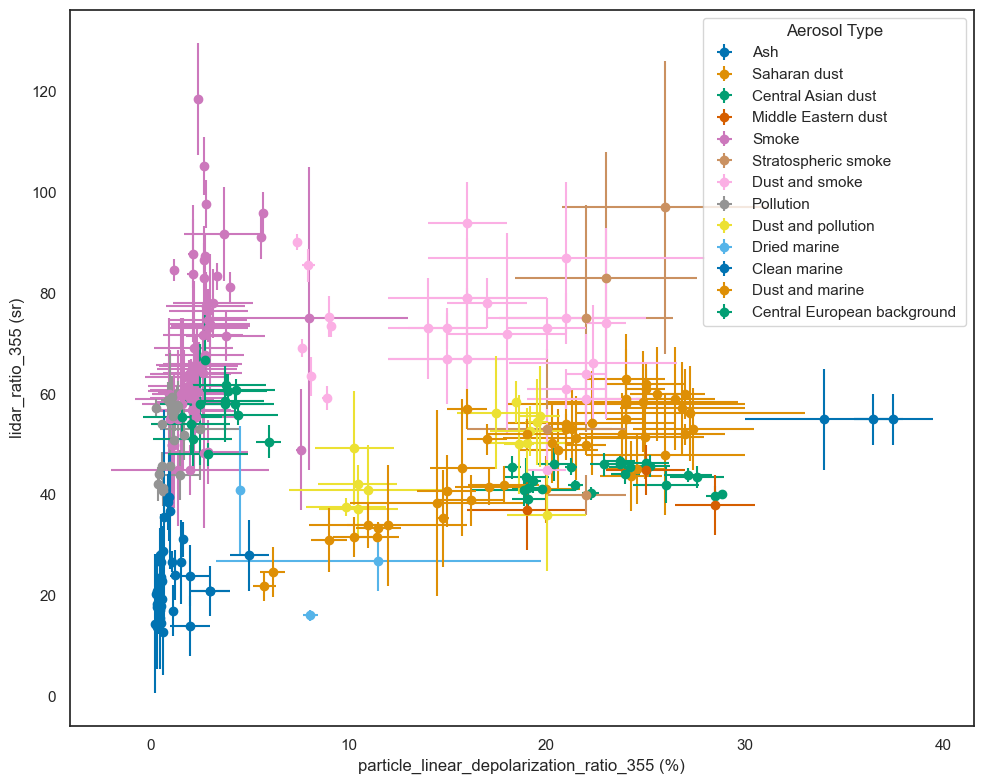

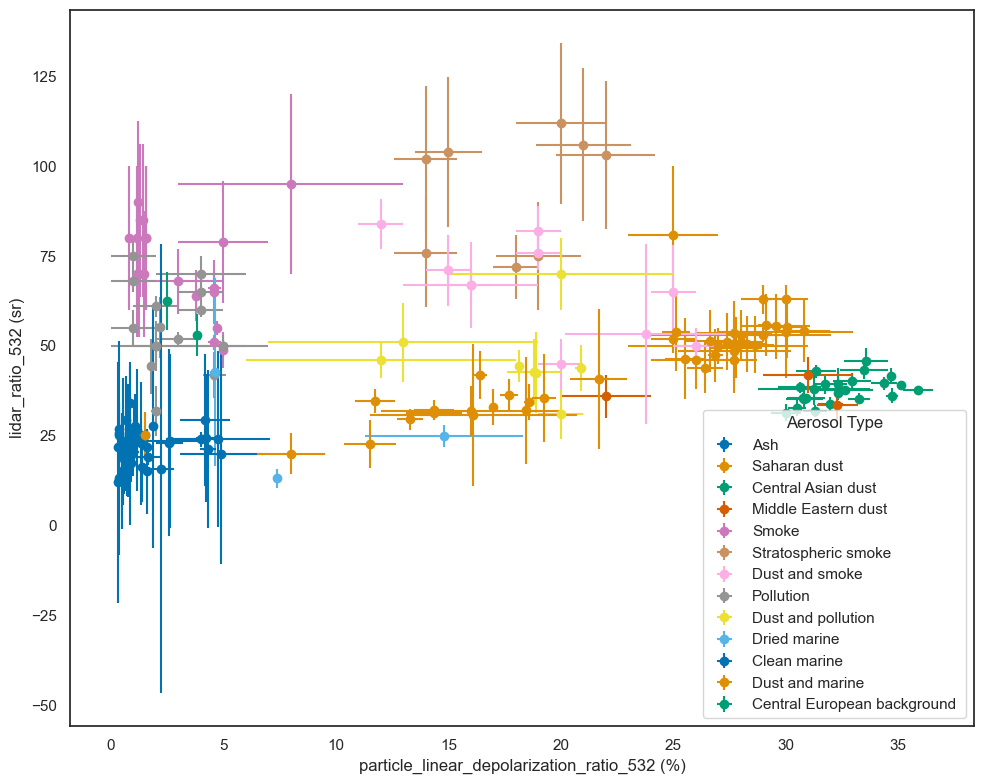

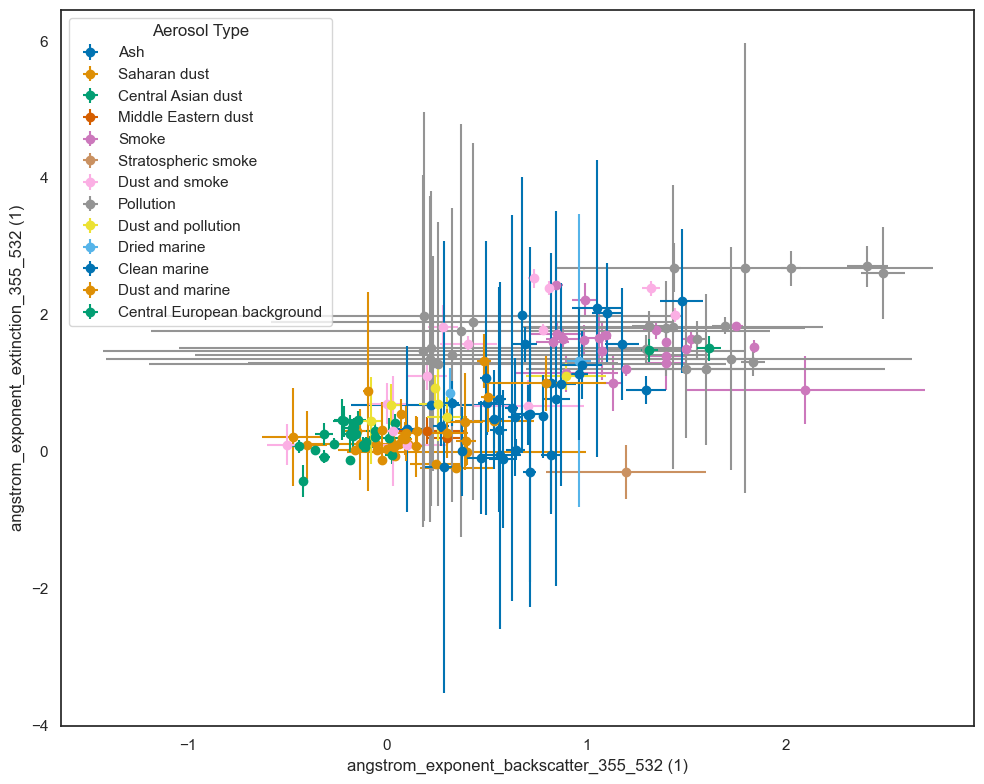

In [12]:
def visualize_with_error(df, x, y):
    plt.figure(figsize=(10, 8))
    sns.set_style("white")
    for aerosol_type in delian_df['aerosol'].unique():
        subset = df[delian_df['aerosol'] == aerosol_type]
        
        valid_subset = subset[(subset['error_' + x] != 9999) & 
                              (subset['error_' + y] != 9999)]
        
        plt.errorbar(valid_subset[x], valid_subset[y],
                    xerr=valid_subset['error_' + x], yerr=valid_subset['error_' + y],
                    fmt = "o", label=aerosol_type)
    
    plt.legend(title='Aerosol Type')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()

visualize_with_error(delian_df, 'particle_linear_depolarization_ratio_355 (%)', 'lidar_ratio_355 (sr)')
visualize_with_error(delian_df, 'particle_linear_depolarization_ratio_532 (%)', 'lidar_ratio_532 (sr)')
visualize_with_error(delian_df, 'angstrom_exponent_backscatter_355_532 (1)', 'angstrom_exponent_extinction_355_532 (1)')

### **Data Imputation**

We impute the error values of a column (variable), i.e. `-9999.0` equals the means (excepting `-9999.0`) of that variable. 

**Note:** we calculate the means and impute for each aerosol, using the `groupby` command.

In [13]:
def mean_without_9999(column):
    mean = column[abs(column) != 9999.].mean()
    return mean

def replace_9999(column):
    mean = mean_without_9999(column)
    column[abs(column) == 9999.] = mean
    return column

df = delian_df.groupby('aerosol', observed=True).transform(replace_9999)

df.head()

,angstrom_exponent_backscatter_355_532 (1),error_angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),error_angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),error_angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),error_lidar_ratio_355 (sr),lidar_ratio_532 (sr),error_lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),error_particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),error_particle_linear_depolarization_ratio_532 (%)
0,0.610000,0.400000,1.025000,0.430000,0.840000,0.63000,55.0,5.0,48.00000,7.500000,36.5,1.000000,NaN,NaN
1,0.610000,0.400000,1.025000,0.430000,0.840000,0.63000,55.0,5.0,48.00000,7.500000,37.5,2.000000,NaN,NaN
2,0.220000,0.400000,1.050000,0.430000,0.680000,0.63000,39.0,10.0,32.00000,4.000000,36.0,2.333333,NaN,NaN
3,1.000000,0.400000,1.000000,0.430000,1.000000,0.63000,55.0,10.0,64.00000,11.000000,34.0,4.000000,NaN,NaN
4,0.028737,0.109849,0.459035,0.117678,0.100489,0.17537,63.0,9.0,53.06897,7.863113,24.0,2.000000,31.0,1.0


We still have the value NaN in two columns `particle_linear_depolarization_ratio_532 (%)` and `error_particle_linear_depolarization_ratio_532 (%)`. That is because this optical property does not have any valid value for the `Ash` aerosol. So we will impute it as the mean of all measured values of all aerosols.

In [14]:
from sklearn.impute import SimpleImputer

# Create an imputer object to fill NaNs with the mean of each column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit the imputer and transform the scaled data to fill in NaNs
df_imputed = imputer.fit_transform(df)

df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

df_imputed.head()

,angstrom_exponent_backscatter_355_532 (1),error_angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),error_angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),error_angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),error_lidar_ratio_355 (sr),lidar_ratio_532 (sr),error_lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),error_particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),error_particle_linear_depolarization_ratio_532 (%)
0,0.610000,0.400000,1.025000,0.430000,0.840000,0.63000,55.0,5.0,48.00000,7.500000,36.5,1.000000,10.883079,0.909911
1,0.610000,0.400000,1.025000,0.430000,0.840000,0.63000,55.0,5.0,48.00000,7.500000,37.5,2.000000,10.883079,0.909911
2,0.220000,0.400000,1.050000,0.430000,0.680000,0.63000,39.0,10.0,32.00000,4.000000,36.0,2.333333,10.883079,0.909911
3,1.000000,0.400000,1.000000,0.430000,1.000000,0.63000,55.0,10.0,64.00000,11.000000,34.0,4.000000,10.883079,0.909911
4,0.028737,0.109849,0.459035,0.117678,0.100489,0.17537,63.0,9.0,53.06897,7.863113,24.0,2.000000,31.000000,1.000000


We check the quality of the imputed data.

In [15]:
df_imputed.duplicated().sum()

0

In [16]:
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
angstrom_exponent_backscatter_355_532 (1),316.0,0.779530,0.617844,-0.500000,0.272608,0.814661,1.365803,2.489430
error_angstrom_exponent_backscatter_355_532 (1),316.0,0.187158,0.268275,0.000214,0.047562,0.100000,0.183696,1.621820
angstrom_exponent_backscatter_532_1064 (1),316.0,0.799295,0.430504,-0.241943,0.491313,0.864506,1.166186,2.148480
error_angstrom_exponent_backscatter_532_1064 (1),316.0,0.168427,0.203761,0.000000,0.054529,0.109771,0.141246,1.151870
angstrom_exponent_extinction_355_532 (1),316.0,0.943316,0.692282,-0.428108,0.356404,0.932919,1.492750,2.706950
error_angstrom_exponent_extinction_355_532 (1),316.0,0.615900,0.651982,0.000501,0.177300,0.360162,0.820808,3.309086
lidar_ratio_355 (sr),316.0,50.673770,19.096687,12.821490,39.963554,51.113568,60.439445,118.548560
error_lidar_ratio_355 (sr),316.0,7.055542,5.290999,0.566400,3.323110,5.576068,9.000000,30.000000
lidar_ratio_532 (sr),316.0,49.166890,20.697239,12.063000,32.055051,48.000000,68.000000,112.000000
error_lidar_ratio_532 (sr),316.0,9.229730,6.964022,0.860434,4.563627,8.020870,11.135828,62.445038


### **Principal Componants Analysis** 

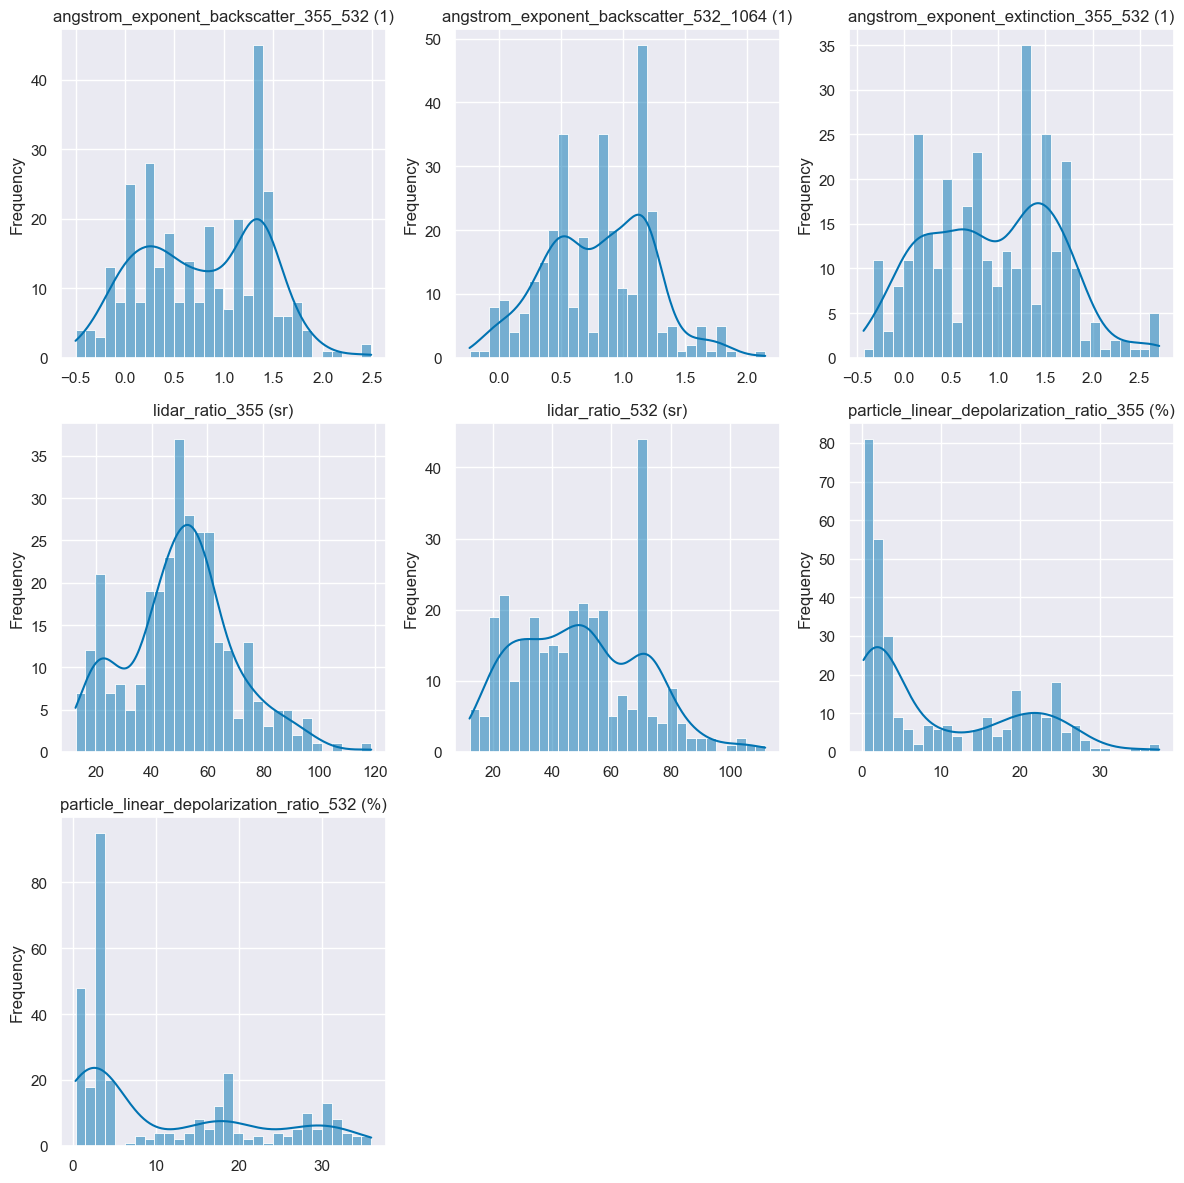

In [17]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, column in enumerate(properties):
    sns.histplot(data=df_imputed[column], bins = 30, kde=True, ax=axes[i])  
    axes[i].set_title(f'{column}')  # Set title for the plot
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel(None)

# Adjust layoutcolumns)
axes[-1].set_visible(False)
axes[-2].set_visible(False)
plt.tight_layout()
plt.show()

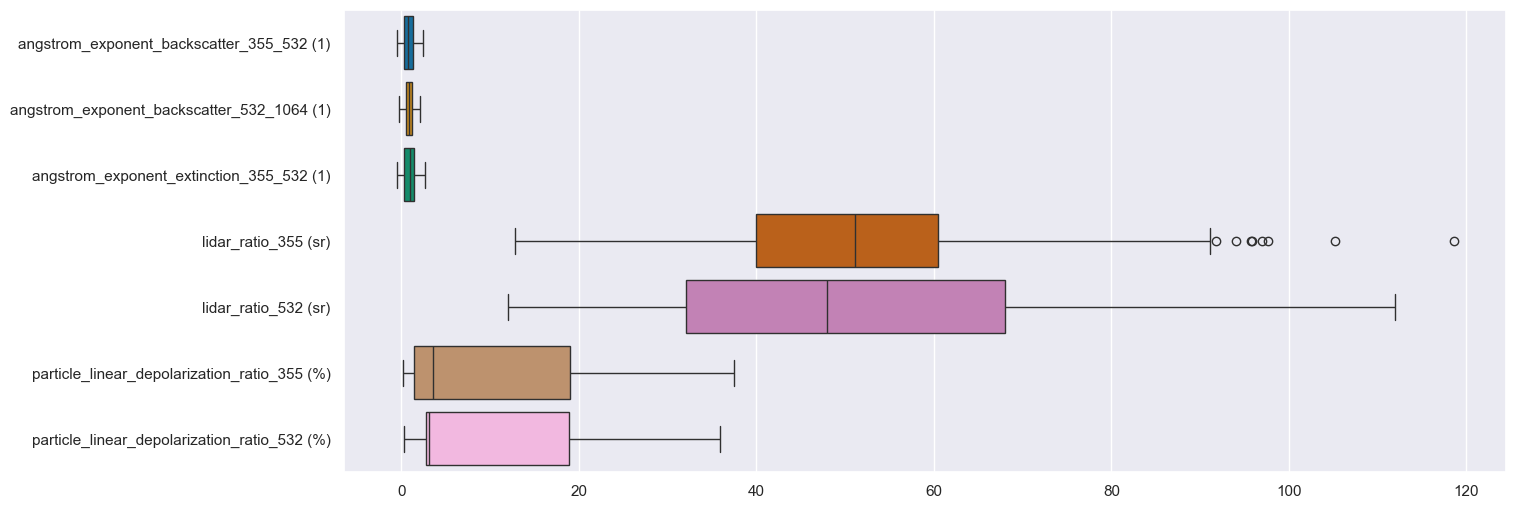

In [18]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_imputed[properties], orient='h')  # 'h' for horizontal boxplots

plt.show()

In [19]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
ss = StandardScaler()

# Fit and transform the data
df_scaled = ss.fit_transform(df_imputed[properties])

# Convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns = properties)

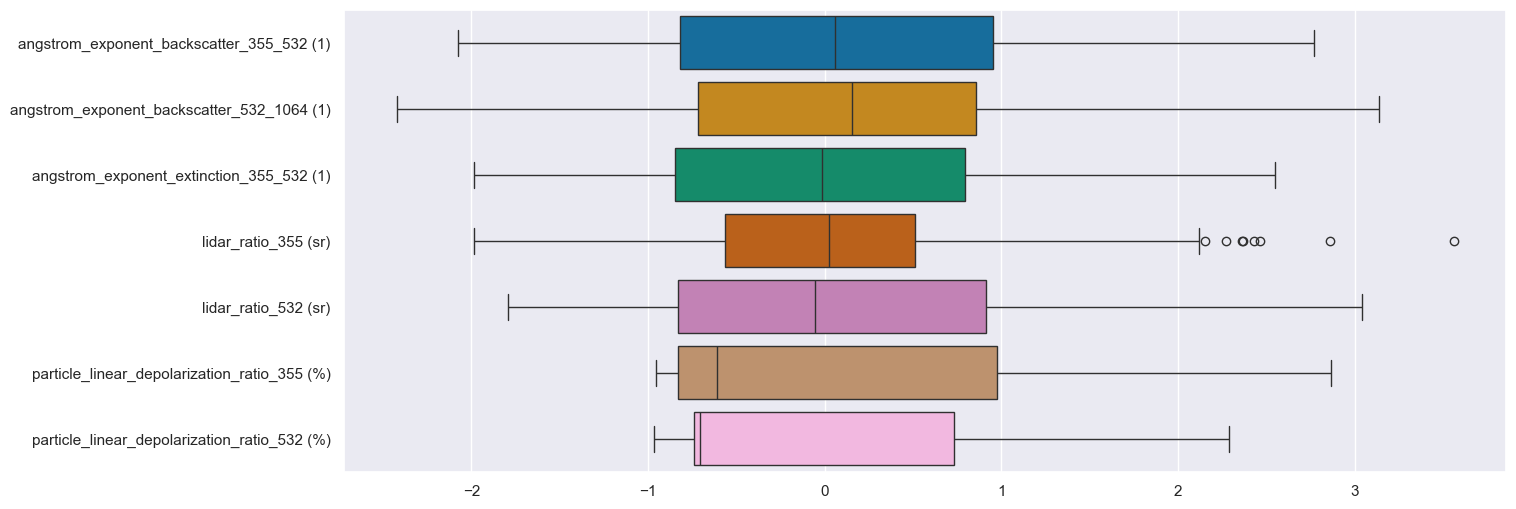

In [20]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_scaled, orient='h')  # 'h' for horizontal boxplots

plt.show()

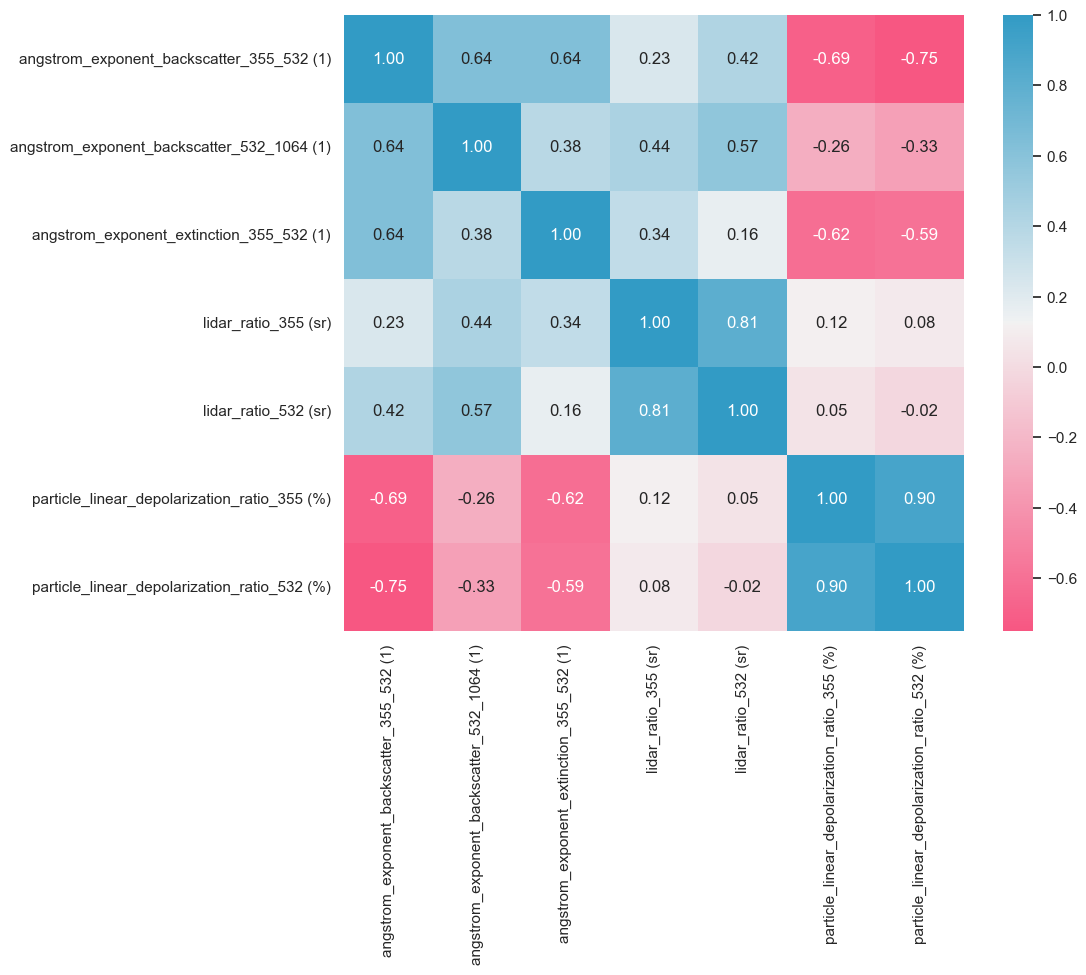

In [21]:
plt.figure(figsize=(10,8))
# correlation between columns
sns.heatmap(df_scaled.corr(), annot=True, fmt='.2f', cmap=cmap)
plt.xticks(rotation=90)

plt.show()

In [22]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

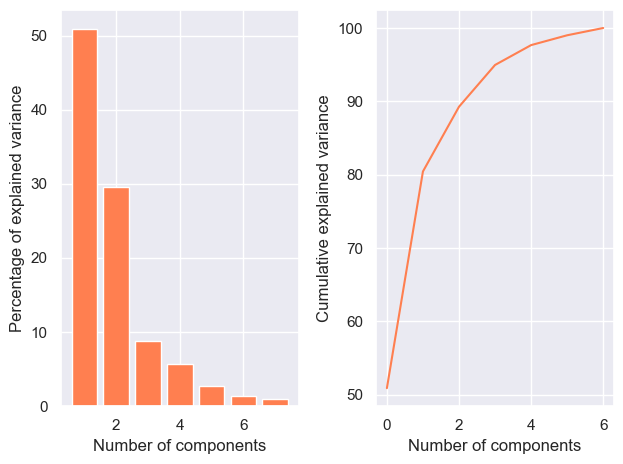

In [23]:
explained_variance_ratio = 100*pca.explained_variance_ratio_

plt.subplot(1,2,1)
n_bars = df_pca.shape[1]
plt.bar(np.arange(1, n_bars+1), explained_variance_ratio[:n_bars], color='coral')
plt.xlabel("Number of components")
plt.ylabel("Percentage of explained variance")

plt.subplot(1,2,2)
plt.plot(np.cumsum(explained_variance_ratio), color='coral')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

plt.tight_layout()
plt.show()

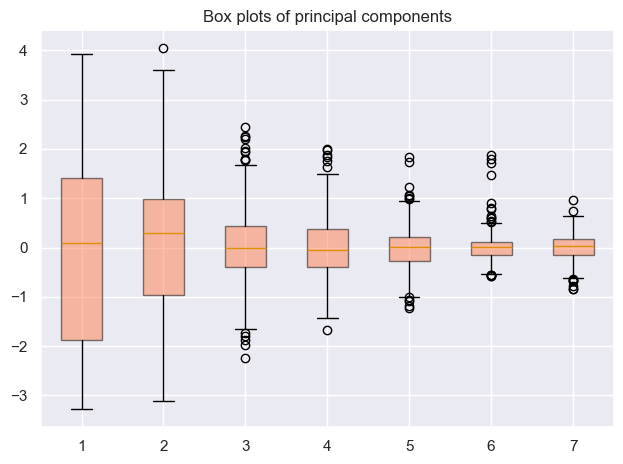

In [24]:
box = plt.boxplot(df_pca, patch_artist=True)
plt.setp(box["boxes"], facecolor="coral", alpha=.5)
plt.title("Box plots of principal components")
plt.tight_layout()
plt.show()

### **Data Augmentation** 
Genrate new data based on the original data with the assumption that the properties follow the normal distributions 
*(we can run this before and after the models to compare the results)*

In [25]:
np.random.seed(28)

def generate_samples(individual_data, n_samples=10):
    means_columns = properties
    errors_columns = ['error_' + col for col in means_columns]
    
    means = individual_data[means_columns].astype(float).values
    errors = individual_data[errors_columns].astype(float).values
    
    generated_list = [individual_data[means_columns].values]  # Include only the properties
    
    # Generate new samples
    for _ in range(n_samples):
        # Generate random samples based on the mean and error values
        generated_values = np.random.normal(means, errors)
        generated_list.append(generated_values)
    
    generated_df = pd.DataFrame(generated_list, columns=means_columns)
    
    return generated_df

In [26]:
# Initialize a list to store DataFrames
generated_data = []

# Iterate over each row in the DataFrame
for index, row in df_imputed.iterrows():
    # Generate samples for the current row
    generated_df = generate_samples(row)
    # Append the DataFrame to the list without adding an index column
    generated_data.append(generated_df)

# Concatenate all DataFrames in the list into one DataFrame
df_generated = pd.concat(generated_data, ignore_index=True)

df_generated

,angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%)
0,0.610000,1.025000,0.840000,55.000000,48.000000,36.500000,10.883079
1,0.788533,1.742722,0.673504,50.160825,48.443913,38.014620,11.189601
2,0.489053,0.664384,0.513829,56.267539,29.364720,35.848580,9.267559
3,0.703714,1.557942,0.430289,53.668925,43.959602,36.920741,10.796376
4,0.302050,0.945998,0.951390,58.685281,53.203970,35.684470,11.235833
...,...,...,...,...,...,...,...
3471,1.306981,1.175807,1.712591,58.336416,48.897914,4.221975,3.172488
3472,1.595998,1.404200,1.543373,61.238770,61.409371,5.879061,3.201316
3473,1.289039,1.261890,1.489336,61.912598,63.250949,5.143399,3.269172
3474,1.289045,1.391607,1.283561,63.255137,48.206918,6.933866,3.202433


In [27]:
#Define a new df containing the label (type of aerosol) of the df_generated
aerosol_generated = []

for col in samples.columns:
  for i in range(int(samples[col].iloc[0]) * 11):
    aerosol_generated.append(col)
    
aerosol_generated = pd.DataFrame({"aerosol": aerosol_generated})

aerosol_generated['aerosol'] = aerosol_generated['aerosol'].astype('category') #convert type from Object to Categorical

aerosol_generated

,aerosol
0,Ash
1,Ash
2,Ash
3,Ash
4,Ash
...,...
3471,Central European background
3472,Central European background
3473,Central European background
3474,Central European background


### **Build the predicted models**

In [28]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

#aerosol_encoder = label_encoder.fit_transform(aerosol.values.flatten())
aerosol_encoder = label_encoder.fit_transform(aerosol_generated.values.flatten())

# Print the mapping of original labels to encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping


{'Ash': 0,
 'Central Asian dust': 1,
 'Central European background ': 2,
 'Clean marine': 3,
 'Dried marine': 4,
 'Dust and marine': 5,
 'Dust and pollution': 6,
 'Dust and smoke': 7,
 'Middle Eastern dust': 8,
 'Pollution': 9,
 'Saharan dust': 10,
 'Smoke': 11,
 'Stratospheric smoke': 12}

Split the data set in a controlled manner to ensure the ratio between the training set and the test set is consistent for each class.

In [29]:
from sklearn.model_selection import train_test_split

#df = df_imputed[properties]
df = df_generated

X_train, X_test, y_train, y_test = train_test_split(df, aerosol_encoder, test_size=0.25, stratify=aerosol_encoder, shuffle=True, random_state=28)

In [30]:
ss.fit(X_train)
X_train = ss.transform(X_train)
# Keep the standardization parameters unchanged for the test set
X_test = ss.transform(X_test)

### **K-Nearest Neighbors**

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

param = {'n_neighbors':list(range(2,20))}

# cv=k means a k-fold cross-validation method was used to evaluate each parameter configuration.
# n_jobs=-1 means use all available CPU cores to speed up the search process.
stratified_k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=28) # Use the appropriate number of splits for the data

knn=GridSearchCV(KNeighborsClassifier(),param,cv=stratified_k_fold,n_jobs=-1, verbose =2)

#knnOpt will be the optimized version of kNN after the search.
knnOpt=knn.fit(X_train, y_train)

print("Best score = %f, Best parameter = %s" % (knnOpt.best_score_,knnOpt.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


Best score = 0.883774, Best parameter = {'n_neighbors': 3}


In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Predict on the test set
y_pred = knnOpt.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8883774453394706
[[ 11   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  62   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0  26   0   0   0   0   0   0   5   0   8   0]
 [  0   0   1 141   1   0   0   0   0   0   0   0   0]
 [  0   0   0   1  15   1   0   0   0   2   0   0   0]
 [  0   0   0   0   0  54   2   1   1   0   0   0   0]
 [  0   0   0   0   0   6  29   5   0   0   1   0   0]
 [  0   0   0   0   0   1   5  60   1   0   2   0   0]
 [  0   2   0   0   0   0   1   0   6   0   2   0   0]
 [  0   0   9   8   0   0   0   0   0  90   0   9   0]
 [  0   4   0   0   0   0   0   0   1   0  77   0   0]
 [  0   0  12   0   0   0   0   0   0   4   0 179   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.91      0.98      0.95        63
           2       0.54      0.67      0.60        39
           3       0.94      0.99     

### **Support Vector Machine (SVM)**

In [33]:
from sklearn.svm import SVC

param = {'C':[0.001,0.01,0.1,1,10,100,1000]}
svm= GridSearchCV(SVC(),param,cv=stratified_k_fold,n_jobs=-1, verbose=2)
svmOpt=svm.fit(X_train, y_train)
print("Best score = %f, Best parameter = %s" % (svmOpt.best_score_,svmOpt.best_params_))

Fitting 3 folds for each of 7 candidates, totalling 21 fits


Best score = 0.902570, Best parameter = {'C': 100}


In [34]:
y_pred = svmOpt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.9148446490218642
[[ 11   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  62   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0  28   0   0   0   0   0   0   5   0   6   0]
 [  0   0   0 141   0   0   0   0   0   2   0   0   0]
 [  0   0   0   0  18   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0  55   3   0   0   0   0   0   0]
 [  0   0   0   0   0   6  31   4   0   0   0   0   0]
 [  0   0   0   0   0   1   2  63   1   0   2   0   0]
 [  0   3   0   0   0   0   1   0   5   0   2   0   0]
 [  0   0   2   6   0   0   0   0   0 101   0   7   0]
 [  0   1   0   0   0   0   0   1   4   0  76   0   0]
 [  0   0  12   0   0   0   0   0   0   1   0 182   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.94      0.98      0.96        63
           2       0.67      0.72      0.69        39
           3       0.96      0.99     

### **Naive Bayes**

In [35]:
from sklearn.naive_bayes import GaussianNB

param = [{'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}]
nb = GridSearchCV(GaussianNB(),param,cv=stratified_k_fold,n_jobs=-1, verbose=2)
nbOpt =nb.fit(X_train, y_train)
print("Best score = %f, Best parameter = %s" % (nbOpt.best_score_,nbOpt.best_params_))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best score = 0.863061, Best parameter = {'var_smoothing': 1e-09}


In [36]:
y_pred = nbOpt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8780207134637514
[[ 11   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  62   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0  35   0   0   0   0   0   0   0   0   4   0]
 [  0   0   0 140   0   1   0   0   0   2   0   0   0]
 [  0   0   0   0  19   0   0   0   0   0   0   0   0]
 [  0   0   0   1   1  47   8   1   0   0   0   0   0]
 [  0   0   0   0   0   8  30   3   0   0   0   0   0]
 [  0   0   0   0   0   1   5  58   0   0   5   0   0]
 [  0   3   0   0   0   0   1   0   4   0   3   0   0]
 [  0   0   6   1   0   1   0   0   0  91   0  17   0]
 [  0   3   0   0   0   1   0   0   3   0  75   0   0]
 [  0   0  17   1   0   0   0   1   0   7   0 169   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.91      0.98      0.95        63
           2       0.60      0.90      0.72        39
           3       0.98      0.98     

### **Decision Tree**

In [37]:
from sklearn.tree import DecisionTreeClassifier

param=[{"max_depth": [1, 2, 4, 8, 16, 32, 64, None]}]

dtc = DecisionTreeClassifier(random_state=28)

tree= GridSearchCV(dtc,param,cv=stratified_k_fold,n_jobs=-1, verbose =2)
treeOpt=tree.fit(X_train, y_train)

print("Best score = %f, Best parameter = %s" % (treeOpt.best_score_,treeOpt.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best score = 0.841580, Best parameter = {'max_depth': 16}


In [38]:
y_pred = treeOpt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8665132336018412
[[ 10   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0  59   0   0   0   0   0   0   2   0   2   0   0]
 [  0   0  31   0   0   0   0   0   0   3   0   5   0]
 [  0   0   0 140   0   0   0   0   0   3   0   0   0]
 [  0   0   0   0  19   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0  52   3   1   0   0   0   1   0]
 [  0   0   0   1   0  11  25   3   1   0   0   0   0]
 [  0   1   0   0   0   1   5  56   1   0   3   0   2]
 [  0   2   0   0   0   0   0   0   6   0   3   0   0]
 [  0   0   5   3   0   1   2   0   0  89   0  16   0]
 [  0   3   0   0   0   0   2   4   4   0  69   0   0]
 [  0   0  10   0   0   0   0   0   0   9   0 176   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0  21]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.91      0.94      0.92        63
           2       0.67      0.79      0.73        39
           3       0.97      0.98     

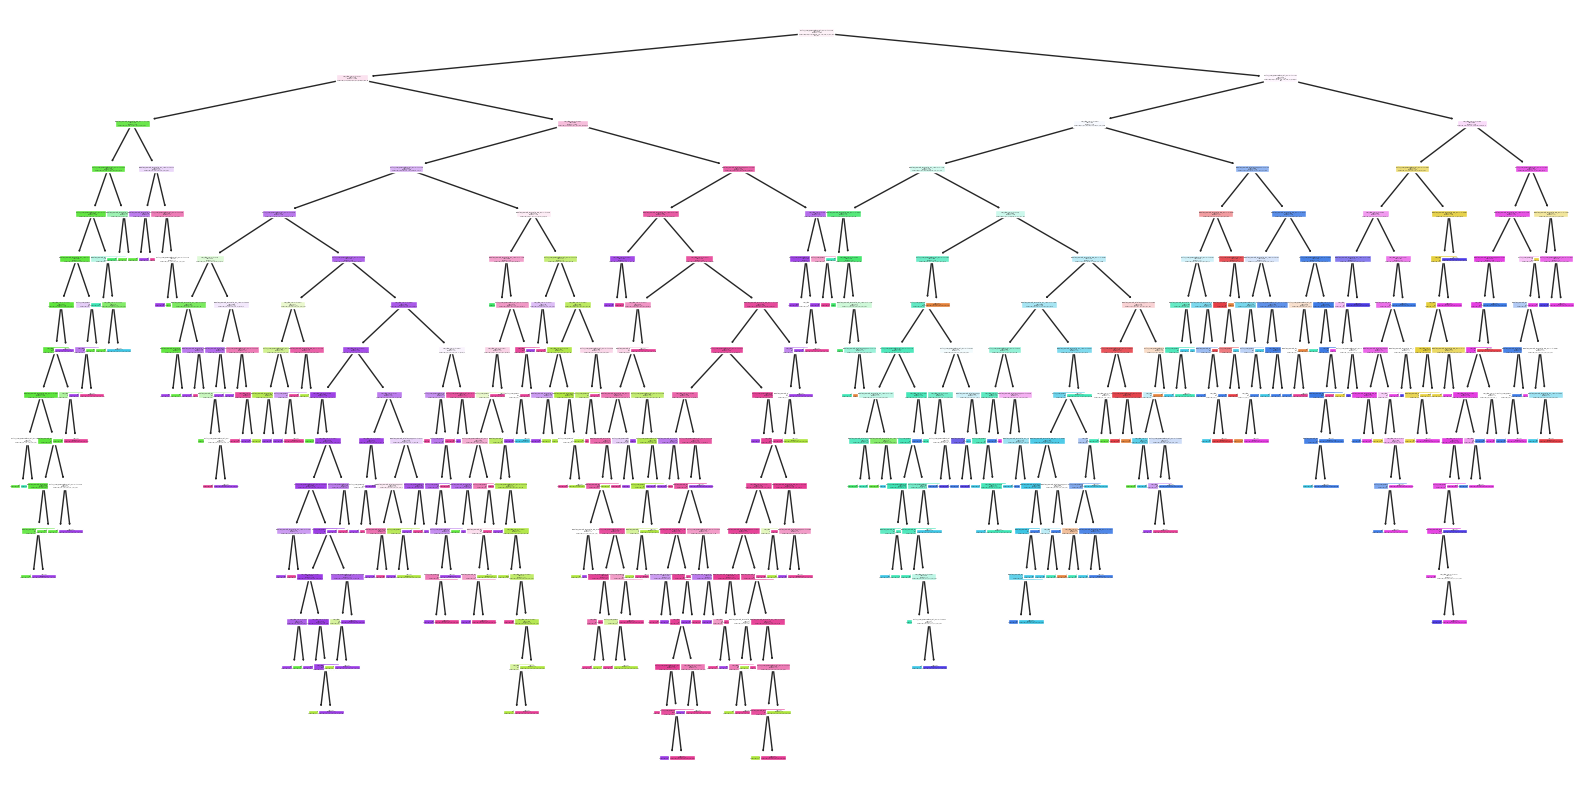

In [39]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10)) 
plot_tree(treeOpt.best_estimator_, filled = True, feature_names=df.columns.tolist())
plt.show() 

### **Random Forest**

In [40]:
from sklearn.ensemble import RandomForestClassifier

param=[{'n_estimators': [50, 100, 500],
        'max_features': [2, 3, 4],
        'max_depth' : [2, 4, 8, None]}]

rf= GridSearchCV(RandomForestClassifier(random_state=28),param,cv=stratified_k_fold,n_jobs=-1, verbose = 2)

rfOpt=rf.fit(X_train, y_train)

print("Best score = %f, Best parameter = %s" % (rfOpt.best_score_,rfOpt.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.921366, Best parameter = {'max_depth': None, 'max_features': 2, 'n_estimators': 500}


In [41]:
y_pred = rfOpt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.9321058688147296
[[ 11   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  62   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0  28   0   0   0   0   0   0   3   0   8   0]
 [  0   0   0 141   0   0   0   0   0   2   0   0   0]
 [  0   0   0   0  19   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  56   2   0   0   0   0   0   0]
 [  0   0   0   0   0   9  28   3   1   0   0   0   0]
 [  0   0   0   0   0   0   3  62   0   0   4   0   0]
 [  0   2   0   0   0   0   1   0   5   0   3   0   0]
 [  0   0   0   3   0   0   0   0   0 106   0   7   0]
 [  0   1   0   0   0   0   0   0   1   0  80   0   0]
 [  0   0   1   0   0   0   0   0   0   4   0 190   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.95      0.98      0.97        63
           2       0.97      0.72      0.82        39
           3       0.98      0.99     

In [42]:
rf= rfOpt.best_estimator_

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(df.columns[indices[f]], importances[indices[f]])

particle_linear_depolarization_ratio_532 (%) 0.21550137734489852
lidar_ratio_355 (sr) 0.1751168161820853
particle_linear_depolarization_ratio_355 (%) 0.15809893927546845
lidar_ratio_532 (sr) 0.14973925594947837
angstrom_exponent_backscatter_355_532 (1) 0.1126261776531716
angstrom_exponent_backscatter_532_1064 (1) 0.10678440655165965
angstrom_exponent_extinction_355_532 (1) 0.08213302704323819


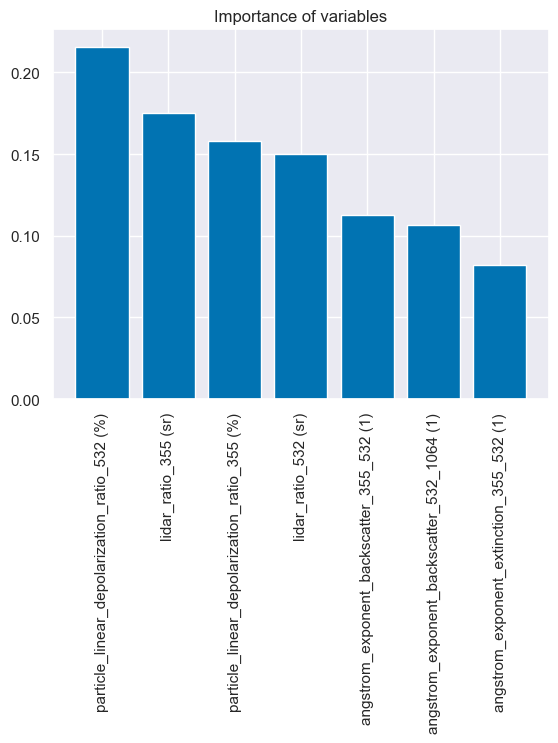

In [43]:
sorted_importances = [df.columns[indices[f]] for f in range(X_train.shape[1])]


plt.figure()
plt.title("Importance of variables")
plt.bar(range(X_train.shape[1]), importances[indices]);
plt.xticks(range(X_train.shape[1]), sorted_importances, rotation=90);
plt.show()

### **Hist Gradient Boosting**

In [44]:
from sklearn.ensemble import HistGradientBoostingClassifier

param = [{
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 8, None],
    'l2_regularization': [0, 0.1, 0.5]
}]
hgb = HistGradientBoostingClassifier(random_state=28)
hgbs = GridSearchCV(hgb, param, cv=stratified_k_fold, n_jobs=-1, verbose=2)

hgbOpt = hgbs.fit(X_train, y_train)

print("Best score = %f, Best parameter = %s" % (hgbOpt.best_score_,hgbOpt.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\buimi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\buimi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Best score = 0.927119, Best parameter = {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 8}


In [45]:
y_pred = hgbOpt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.9332566168009206
[[ 11   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  62   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0  33   0   0   0   0   0   0   1   0   5   0]
 [  0   0   0 139   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0  19   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  56   1   1   0   0   0   0   0]
 [  0   0   0   0   0  10  29   2   0   0   0   0   0]
 [  0   0   0   0   0   0   4  63   0   0   2   0   0]
 [  0   2   0   0   0   0   1   0   6   0   2   0   0]
 [  0   0   1   0   0   0   0   0   0 108   0   7   0]
 [  0   1   0   0   1   0   0   0   3   0  77   0   0]
 [  0   0   4   0   0   0   0   0   0   5   0 186   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.95      0.98      0.97        63
           2       0.87      0.85      0.86        39
           3       1.00      0.97     

### **Extreme Gradient Boosting (XGBoost)**

In [46]:
import xgboost
from xgboost import XGBClassifier

param = [{
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 8, None]
}]

xgb = XGBClassifier(eval_metric='logloss', random_state=28)
xgbs = GridSearchCV(xgb, param, cv=stratified_k_fold, n_jobs=-1, verbose=2)

xgbOpt = xgbs.fit(X_train, y_train)

print("Best score = %f, Best parameter = %s" % (xgbOpt.best_score_,xgbOpt.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.927886, Best parameter = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}


In [47]:
y_pred = xgbOpt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.9309551208285386
[[ 11   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  62   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0  32   0   0   0   0   0   0   2   0   5   0]
 [  0   0   0 141   0   0   0   0   0   2   0   0   0]
 [  0   0   0   0  19   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  56   2   0   0   0   0   0   0]
 [  0   0   0   0   0  10  29   2   0   0   0   0   0]
 [  0   0   0   0   0   0   1  66   0   0   2   0   0]
 [  0   2   0   0   0   0   1   0   6   0   2   0   0]
 [  0   0   0   1   0   0   0   0   0 107   0   8   0]
 [  0   1   0   0   0   0   1   0   3   0  77   0   0]
 [  0   0   5   0   0   0   1   1   0   7   0 181   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.95      0.98      0.97        63
           2       0.86      0.82      0.84        39
           3       0.99      0.99     